### Q&A

**Propose a new method to initialize cluster centroids for K-means. List the advantages and disadvantages of Forgy, Random Partition, and your own initializations.**

---

**Method:** Maximin Initialization

**Idea:** Choose the first centroid randomly. For each subsequent centroid, select the point that is **farthest** from the **nearest** previously chosen centroid (maximize the minimum distance).

**Steps:**
1. Randomly select the first centroid from the data points.
2. For each of the remaining *K-1* centroids:
  - Compute the distance from each data point to its **nearest** already chosen centroid.
   - Choose the data point with the **maximum** of these minimum distances as the next centroid.

**Comparison of Initialization Methods**

| Method               | Description                                                               | Advantages                                                                                     | Disadvantages                                                                             |
|----------------------|---------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| **Forgy**            | Randomly choose K points from the dataset as initial centroids            | - Simple and fast  <br> - Often good with well-separated clusters                             | - Sensitive to outliers  <br> - Can select close points leading to poor clustering        |
| **Random Partition** | Randomly assign each point to a cluster, then compute initial centroids   | - Ensures all clusters start with points  <br> - Easy to implement                            | - Can give poor starting centroids  <br> - Often leads to slow convergence                |
| **Maximin (Proposed)** | Choose centroids to be as far apart as possible                          | - Good initial spread of centroids  <br> - Reduces chance of local minima  <br> - More robust to initial position | - Slower than Forgy  <br> - Can still be sensitive to outliers           |


---

**Describe how you can use clustering to speed up the KNN model. Hint: what is kd-tree?**

---

**Problem:** K-Nearest Neighbors (KNN) is a simple and effective algorithm, but it becomes very slow on large datasets because it must compute the distance from the query point to every training point during prediction.

**Solution:** Use Clustering to Reduce the Search Space

Instead of comparing the query point to the entire dataset, we first divide the data into clusters. Then, during prediction, we only search for nearest neighbors within the most relevant cluster(s), greatly reducing the number of comparisons.

**Steps:**

1. Clustering (Preprocessing):
- Use a clustering algorithm like K-Means to group the training data into C clusters.

2. Prediction:
- When a new data point needs to be classified, find the cluster whose centroid is closest to it.
- Then search for the K nearest neighbors only within that cluster (or top-N closest clusters).

**Benefit:** Much faster prediction with minimal loss in accuracy, especially when the clusters are well-formed.

**Result:**
- Instead of comparing to **all N training points**, you're comparing to only **a fraction** of the data.
- This can **greatly speed up prediction time** with **minimal loss in accuracy**, especially if the clusters are tight.

---

**What is a KD-Tree?**

A **KD-tree (k-dimensional tree)** is a data structure for organizing points in a k-dimensional space, useful for efficient nearest-neighbor searches.

**Steps:**
- Recursively partition the space into two halves (like a binary tree), alternating dimensions at each level.
- Each node contains a subset of points and a splitting hyperplane.

**Using KD-Tree in KNN:**
- Build a KD-tree from the training data.
- During prediction, use the tree to eliminate large portions of the dataset from search.
- This reduces time complexity from **O(N)** to approximately **O(log N)** in low dimensions.

**Combining Both: Clustering + KD-Tree**

1. **Cluster** the data into C groups.
2. **Build a KD-tree** for each cluster.
3. **At prediction time**:
   - First find the nearest cluster.
   - Then use the KD-tree of that cluster to efficiently search for neighbors.


**Summary**

| Technique            | Purpose                                | Benefit                        |
|----------------------|----------------------------------------|--------------------------------|
| Clustering           | Reduces search space                   | Speeds up prediction           |
| KD-Tree              | Efficient nearest neighbor search      | Reduces distance computations  |
| Clustering + KD-Tree | Combines both for max performance      | Fast + scalable KNN            |

### Import

In [244]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KDTree, NearestNeighbors, NearestCentroid, KNeighborsClassifier
from sklearn.mixture import GaussianMixture

from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances, mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

### Preprocessing



In [ ]:
train = pd.read_json('./drive/MyDrive/data/train.json')
test = pd.read_json('./drive/MyDrive/data/test.json')

In [222]:
def remove_outliers_iqr(df, features):
  df_clean = df.copy()
  for feature in features:
    Q1 = df_clean[feature].quantile(0.25)
    Q3 = df_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]
  return df_clean

#### Feature extraction

In [223]:
mapping = {'low': 0, 'medium': 1, 'high': 2}
train['interest_level'] = train['interest_level'].map(mapping)

In [224]:
train['features'] = train['features'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
train['features'] = train['features'].replace(r"[\[\]'\"]", "", regex=True)

In [225]:
all_features = []
for _, row in train.iterrows():
    features = row['features'].split(',') if isinstance(row['features'], str) else []
    all_features.extend([feature.strip() for feature in features if feature.strip()])

In [226]:
from collections import Counter

feature_counts = Counter(all_features)
top_20_features = feature_counts.most_common(20)

for feature, _ in top_20_features:
  train[feature] = train['features'].apply(lambda x: 1 if feature in x else 0)

#### Outliers detection

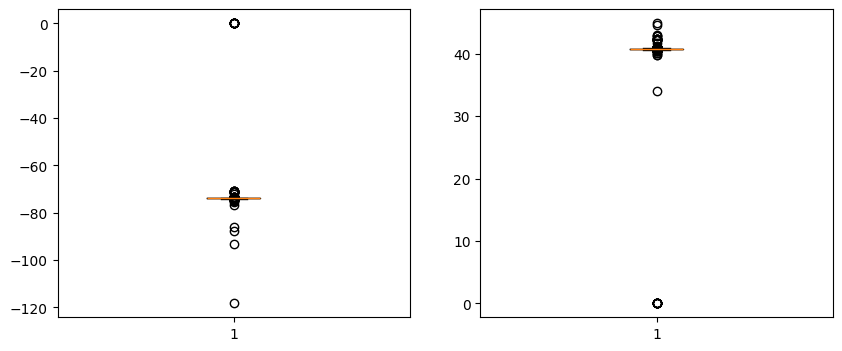

In [227]:
X_train = train[['longitude', 'latitude']]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(train[['longitude']])
plt.subplot(1, 2, 2)
plt.boxplot(train[['latitude']])
plt.show()

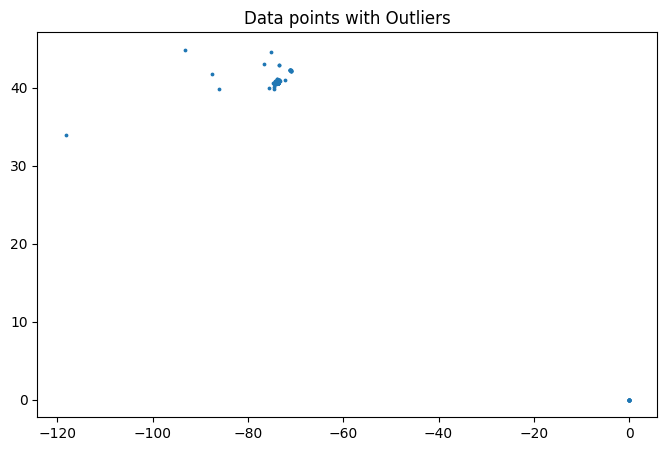

In [228]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train['longitude'], X_train['latitude'], s=3)
plt.title('Data points with Outliers')
plt.show()

Z-score test for detecting outliers

20 outliers detected by Z-score


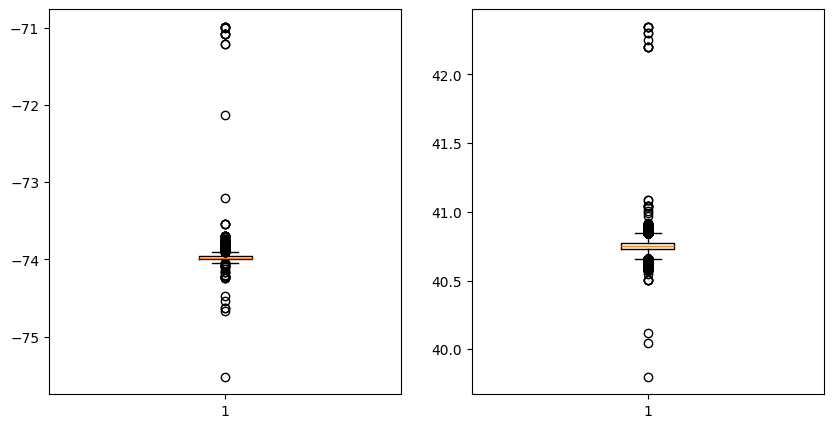

In [229]:
coords = X_train[['longitude', 'latitude']].values
mean = np.mean(coords, axis=0)
std = np.std(coords, axis=0)
z_scores = (coords - mean) / std
outliers_z = np.any(np.abs(z_scores) > 3, axis=1)
outlier_points = X_train[outliers_z]
print(f"{len(outlier_points)} outliers detected by Z-score")

X_train_inliers_z = X_train[~outliers_z]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(X_train_inliers_z[['longitude']])
plt.subplot(1, 2, 2)
plt.boxplot(X_train_inliers_z[['latitude']])
plt.show()

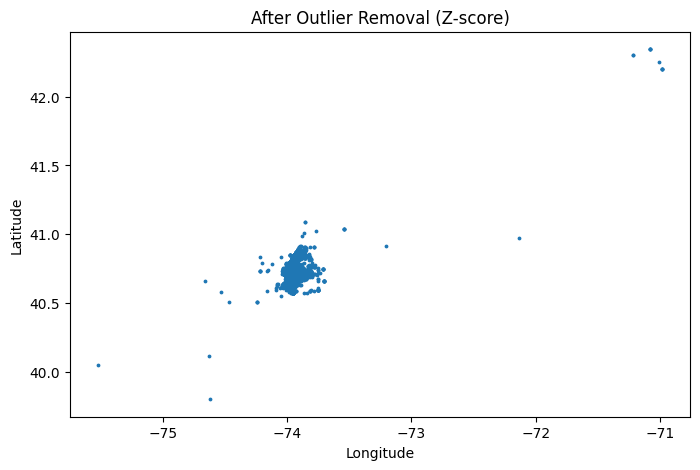

In [230]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train_inliers_z['longitude'], X_train_inliers_z['latitude'], s=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('After Outlier Removal (Z-score)')
plt.show()

Outlier detection with IQR test

2811 outliers detected by IQR


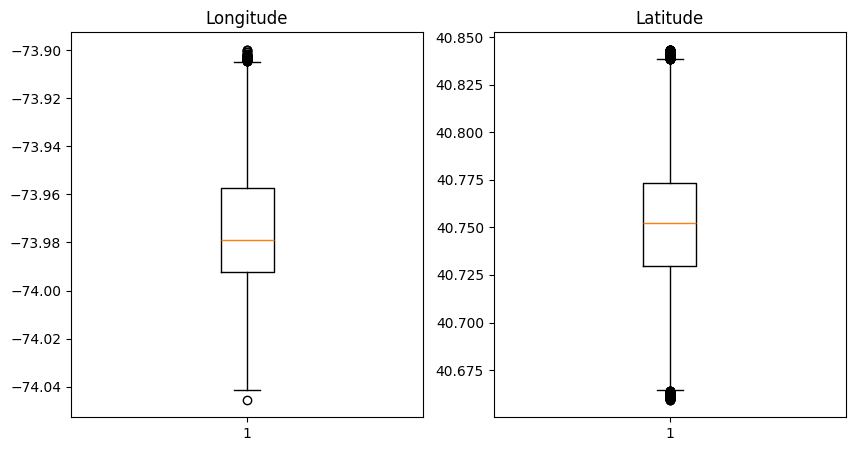

In [231]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

outliers_mask = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_points_iqr = X_train[outliers_mask]
print(f"{len(outlier_points_iqr)} outliers detected by IQR")

X_train_inliers_iqr = X_train[~outliers_mask]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(X_train_inliers_iqr[['longitude']])
plt.title('Longitude')
plt.subplot(1, 2, 2)
plt.boxplot(X_train_inliers_iqr[['latitude']])
plt.title('Latitude')
plt.show()

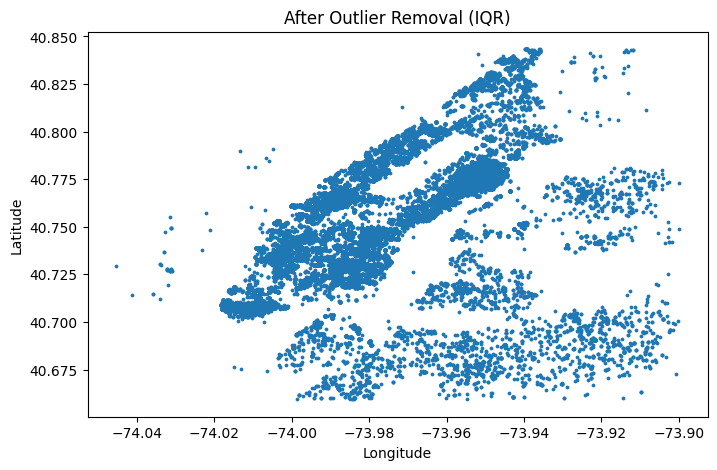

In [232]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train_inliers_iqr['longitude'], X_train_inliers_iqr['latitude'], s=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('After Outlier Removal (IQR)')
plt.show()

In [233]:
X_test = test[['longitude', 'latitude']]
Q_1 = X_test.quantile(0.25)
Q_3 = X_test.quantile(0.75)
IQR = Q3 - Q1
outliers_mask = ((X_test < (Q1 - 1.5 * IQR)) | (X_test > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_points_iqr = X_test[outliers_mask]
print(f"{len(outlier_points_iqr)} outliers detected by IQR")

X_test_inliers_iqr = X_test[~outliers_mask]

4333 outliers detected by IQR


#### Datasets

In [234]:
X_train = X_train_inliers_iqr
X_test = X_test_inliers_iqr

y_train = train['price'][X_train_inliers_iqr.index]
y_test = test['price'][X_test_inliers_iqr.index]

In [235]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(46541, 2) (46541,)
(70326, 2) (70326,)


### K-means

In [ ]:
class KMeansCustom:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.choice(X.index, self.n_clusters, replace=False)
        self.centroids = X.loc[random_idx].to_numpy()

        X = X.to_numpy()
        for _ in range(self.max_iter):
            clusters = self._assign_clusters(X)
            new_centroids = np.array([X[clusters == i].mean(axis=0) if np.any(clusters == i) else self.centroids[i]
                                      for i in range(self.n_clusters)])
            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids
            if shift < self.tol:
                break

        self.clusters = self._assign_clusters(X)

    def predict(self, X):
        return self._assign_clusters(X)

    def _assign_clusters(self, X):
        X = np.asarray(X)
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(dists, axis=1)

    def inertia(self, X):
        X = np.asarray(X)
        return sum(np.min(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)**2, axis=1))


In [110]:
def plot(X, labels, alg, set=None):
  plt.scatter(X.values[:, 0], X.values[:, 1], c=labels, cmap='tab20', s=3)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.title(f"{alg} Clustering ({set if set else ''})")
  plt.colorbar(label="Cluster")
  plt.grid(True)

def lasso_coef(X, y, labels):
  X_aug = X.copy()
  X_aug['cluster'] = labels
  model = make_pipeline(MinMaxScaler(), Lasso(alpha=0.01))
  model.fit(X_aug, y)
  print("Top Feature Importances (Lasso Coefficients):")
  for name, coef in zip(X_aug.columns, model.named_steps['lasso'].coef_):
    print(f"{name:20s}: {coef:.5f}")

Custom K-means Silhouette Score: 0.4092222076983102
Custom K-means Distortion: 1.8231661134358885


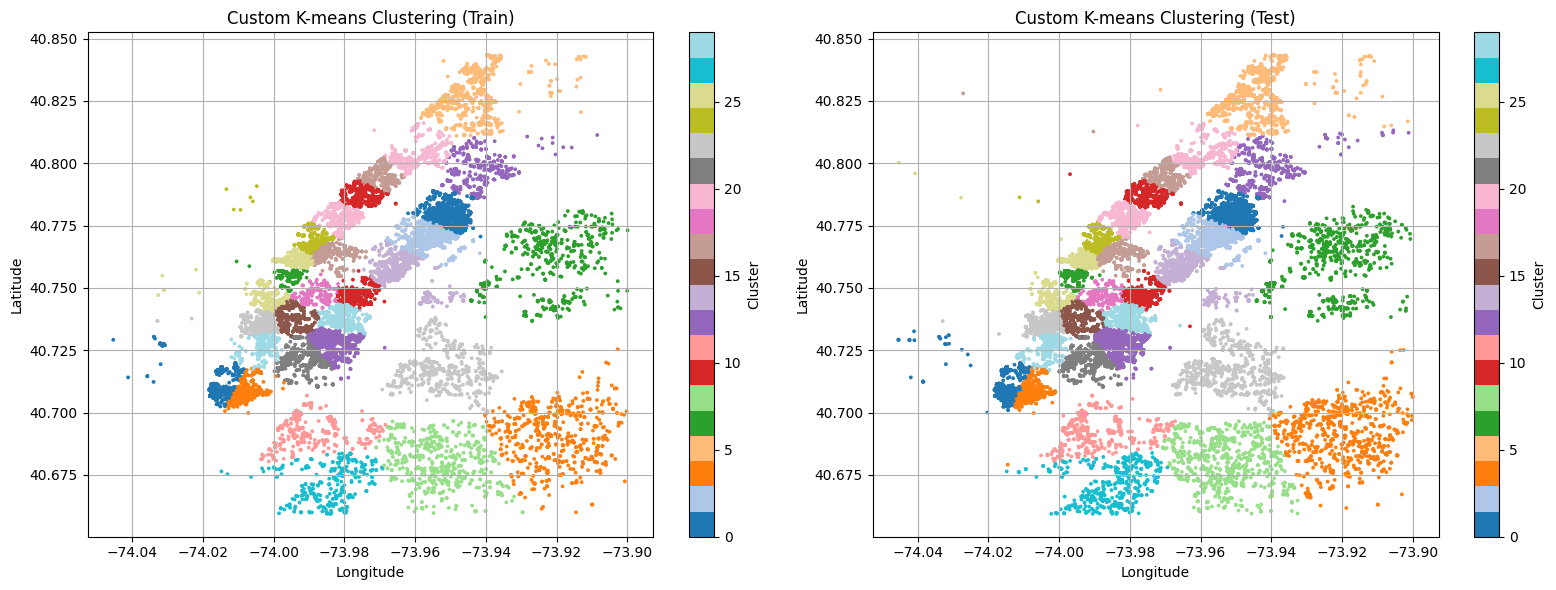

In [ ]:
kmeans = KMeansCustom(n_clusters=30, random_state=42)
kmeans.fit(X_train)

train_labels_custom = kmeans.predict(X_train)
test_labels_custom = kmeans.predict(X_test)

print("Custom K-means Silhouette Score:", silhouette_score(X_train, train_labels_custom))
print("Custom K-means Distortion:", kmeans.inertia(X_train))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot(X_train, train_labels_custom, 'Custom K-means', 'Train')
plt.subplot(1, 2, 2)
plot(X_test, test_labels_custom, 'Custom K-means', 'Test')
plt.tight_layout()
plt.show()

**Silhouette** score helps judge **cluster separation & cohesion**, higher is better.

**Inertia** measures **tightness of clusters**, lower is better.

In [ ]:
lasso_coef(X_train, y_train, train_labels_custom)

Top Feature Importances (Lasso Coefficients):
longitude           : -3482.98952
latitude            : 1021.99647
cluster             : 478.23330


Larger absolute values indicate **higher importance**.

- Longitude is the dominant feature with a strong negative impact on the prediction.

- Latitude has a strong positive impact but less than longitude.

- Cluster contributes positively but with smaller magnitude compared to spatial coordinates.



Sklearn K-means Silhouette Score: 0.4213067690498923
Sklearn K-means Distortion: 1.5926208768506613


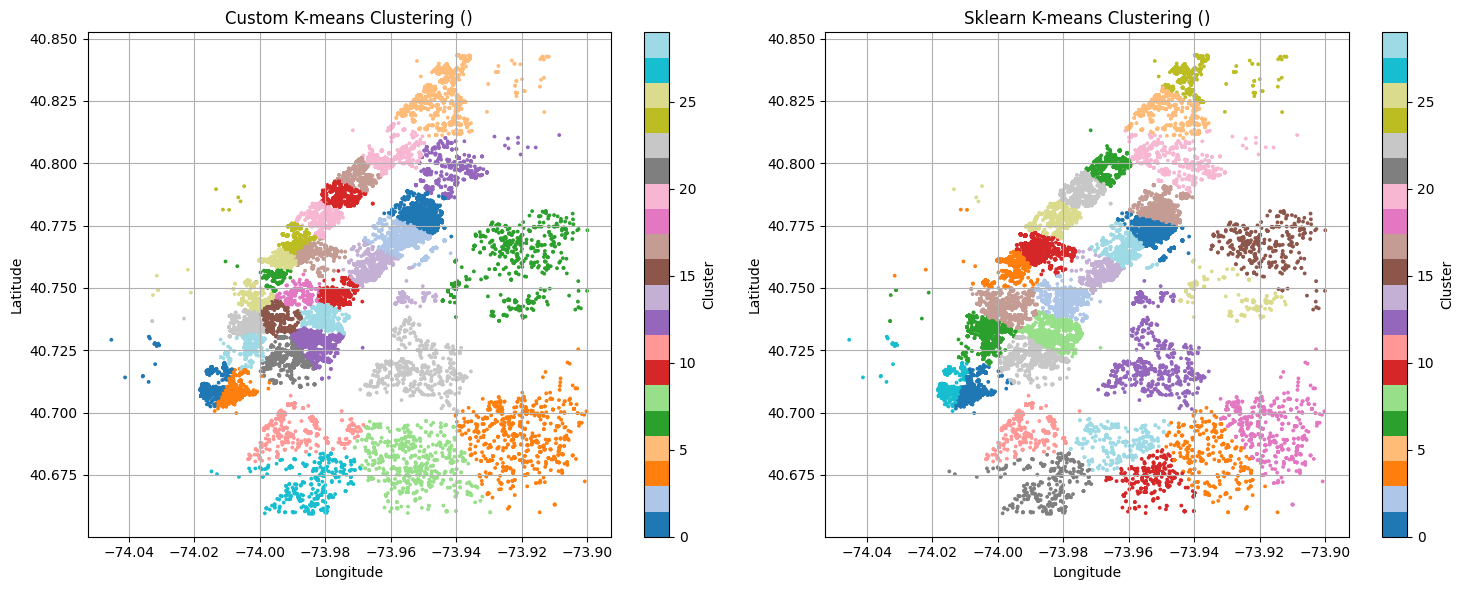

In [ ]:
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(X_train)

train_labels_sklearn = kmeans.predict(X_train)
test_labels_sklearn = kmeans.predict(X_test)

print("Sklearn K-means Silhouette Score:", silhouette_score(X_train, train_labels_sklearn))
print("Sklearn K-means Distortion:", kmeans.inertia_)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot(X_train, train_labels_custom, 'Custom K-means')
plt.subplot(1, 2, 2)
plot(X_train, train_labels_sklearn, 'Sklearn K-means')
plt.tight_layout()
plt.show()

**Analysis**

The plots compare custom and Scikit-learn KMeans clustering on location data (latitude and longitude). While both approaches reveal spatial structure, the Scikit-learn version produces tighter, more coherent clusters. This is confirmed by better *Silhouette Score* and lower *Distortion*, suggesting improved internal consistency and separation between clusters. Such spatial segmentation may reflect neighborhoods or zones, which can be useful for modeling location-dependent behavior.

### DBScan

In [107]:
class DBSCAN_Custom:
    def __init__(self, eps=0.005, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n = len(X)
        self.labels_ = np.full(n, -1, dtype=int)
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0
        tree = KDTree(X)

        for i in range(n):
            if visited[i]:
                continue
            visited[i] = True
            neighbors = tree.query_radius(X[i].reshape(1, -1), r=self.eps)[0]

            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1  # noise
            else:
                self._expand_cluster(i, cluster_id, neighbors, visited, tree, X)
                cluster_id += 1
        return self

    def _expand_cluster(self, idx, cluster_id, neighbors, visited, tree, X):
        self.labels_[idx] = cluster_id
        queue = list(neighbors)

        while queue:
            point = queue.pop()
            if not visited[point]:
                visited[point] = True
                new_neighbors = tree.query_radius(X[point].reshape(1, -1), r=self.eps)[0]
                if len(new_neighbors) >= self.min_samples:
                    queue.extend([n for n in new_neighbors if n not in queue])
            if self.labels_[point] == -1:
                self.labels_[point] = cluster_id

In [108]:
def distortion(X, labels):
  distortion = 0
  for cluster in set(labels):
    cluster_points = X[labels == cluster]
    centroid = cluster_points.mean(axis=0)
    sq_distances = np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
    distortion += sq_distances
  return distortion

Time taken: 55.0561842918396
Silhouette Score: -0.0185
Distortion: 5.8204


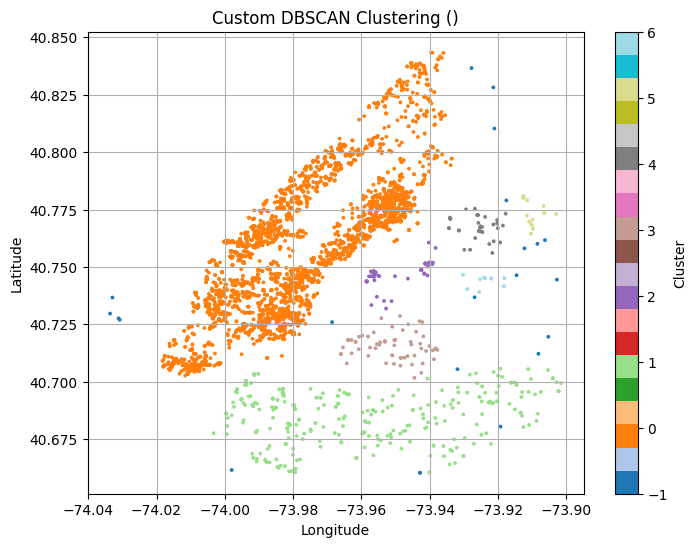

In [112]:
X_sub = X_train.sample(n=5000)
y_sub = train['price'][X_sub.index].values

start = time.time()
dbscan_custom = DBSCAN_Custom(eps=0.0075, min_samples=10)
dbscan_custom.fit(X_sub.values)
labels_custom = dbscan_custom.labels_
print("Time taken:", time.time() - start)

print(f"Silhouette Score: {silhouette_score(X_sub, labels_custom):.4f}")
print(f"Distortion: {distortion(X_sub, labels_custom):.4f}")

plt.figure(figsize=(8, 6))
plot(X_sub, labels_custom, 'Custom DBSCAN')
plt.show()

In [113]:
lasso_coef(X_sub, y_sub, labels_custom)

Top Feature Importances (Lasso Coefficients):
longitude           : -2420.85837
latitude            : 480.06242
cluster             : -823.72765


Silhouette Score: -0.0370
Distortion: 54.8630


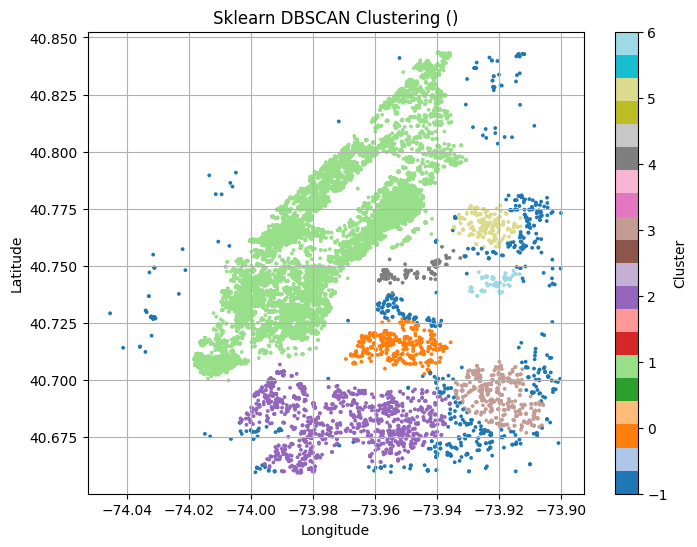

In [114]:
dbscan = DBSCAN(eps=0.005, min_samples=60, n_jobs=-1)
labels_sklearn = dbscan.fit_predict(X_train.values)

print(f"Silhouette Score: {silhouette_score(X_train, labels_sklearn):.4f}")
print(f"Distortion: {distortion(X_train, labels_sklearn):.4f}")

plt.figure(figsize=(8, 6))
plot(X_train, labels_sklearn, 'Sklearn DBSCAN')
plt.show()

In [188]:
train_df = pd.merge(X_train, y_train, how='outer', left_index=True, right_index=True)
test_df = pd.merge(X_test, y_test, how='outer', left_index=True, right_index=True)

train_df_clean = remove_outliers_iqr(train_df, train_df.columns)
test_df_clean = remove_outliers_iqr(test_df, test_df.columns)

X_train_db, y_train_db = train_df_clean.iloc[:, :-1], train_df_clean.iloc[:, -1]
X_test_db, y_test_db = test_df_clean.iloc[:, :-1], test_df_clean.iloc[:, -1]

In [192]:
eps_list = [0.0035, 0.0045, 0.0055]
min_samples_list = [60, 70, 80]

results = []
start = time.time()

for eps in eps_list:
  for min_samples in min_samples_list:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_train = dbscan.fit_predict(X_train_db.values)

    if len(set(labels_train[labels_train != -1])) < 2:
      continue

    mask = labels_train != -1
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_db.values[mask], labels_train[mask])
    labels_test = knn.predict(X_test_db.values)

    X_train_aug = X_train_db.copy()
    X_test_aug = X_test_db.copy()
    X_train_aug['cluster'] = labels_train
    X_test_aug['cluster'] = labels_test

    model = make_pipeline(MinMaxScaler(), Lasso(alpha=0.1))
    model.fit(X_train_aug, y_train_db)
    y_pred = model.predict(X_test_aug)
    r2 = r2_score(y_test_db, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_db, y_pred))

    results.append({
      'eps': eps,
      'min_samples': min_samples,
      'r2': r2,
      'rmse': rmse,
      'model': model,
      'X_train_aug': X_train_aug,
      'labels_train': labels_train
    })

print("Time taken:", time.time() - start)

Time taken: 46.7049765586853


In [193]:
best_results = sorted(results, key=lambda x: x['r2'], reverse=True)

for i, res in enumerate(best_results[:3]):
    print(f"\nTop Model {i+1}")
    print(f"eps={res['eps']}, min_samples={res['min_samples']}")
    print(f"R²: {res['r2']:.4f}")
    print(f"RMSE: {res['rmse']:.4f}")

    print("Top Feature Importances:")
    for name, coef in zip(res['X_train_aug'].columns, res['model'].named_steps['lasso'].coef_):
        print(f"{name:20s}: {coef:.5f}")


Top Model 1
eps=0.0045, min_samples=70
R²: 0.0971
RMSE: 976.4751
Top Feature Importances:
longitude           : -1684.93815
latitude            : -100.23466
cluster             : -416.73675

Top Model 2
eps=0.0045, min_samples=60
R²: 0.0944
RMSE: 977.9526
Top Feature Importances:
longitude           : -1720.04972
latitude            : -115.94796
cluster             : -364.67069

Top Model 3
eps=0.0055, min_samples=80
R²: 0.0933
RMSE: 978.5443
Top Feature Importances:
longitude           : -1731.20971
latitude            : -77.20674
cluster             : -253.08129


Silhouette Score: -0.1194
Distortion: 40.3277


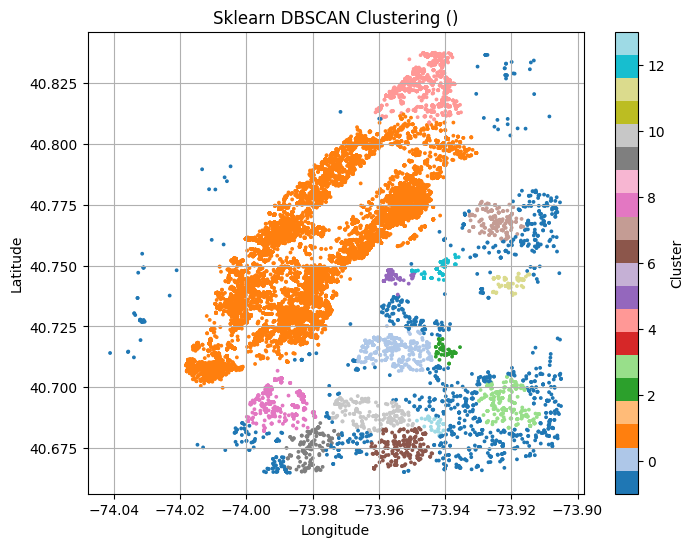

In [194]:
best_eps, best_min_samples = best_results[0]['eps'], best_results[0]['min_samples']

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
labels_sklearn = dbscan.fit_predict(X_train.values)

print(f"Silhouette Score: {silhouette_score(X_train, labels_sklearn):.4f}")
print(f"Distortion: {distortion(X_train, labels_sklearn):.4f}")

plt.figure(figsize=(8, 6))
plot(X_train, labels_sklearn, 'Sklearn DBSCAN')
plt.show()

### AgglomerativeClustering

Silhouette Score: 0.4320
Distortion: 0.71


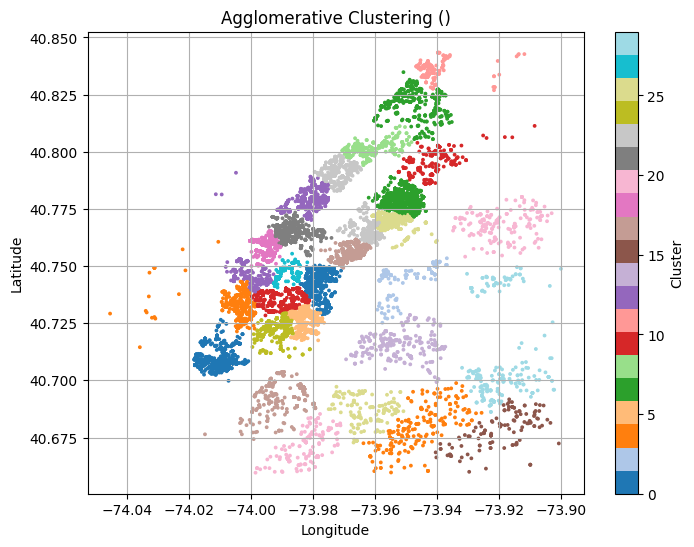

In [ ]:
X_sub = X_train.sample(20000)
y_sub = train['price'].loc[X_sub.index].values

agglom = AgglomerativeClustering(n_clusters=30)
labels_agg = agglom.fit_predict(X_sub)

print(f"Silhouette Score: {silhouette_score(X_sub, labels_agg):.4f}")
print(f"Distortion: {distortion(X_sub, labels_agg):.2f}")

plt.figure(figsize=(8, 6))
plot(X_sub, labels_agg, 'Agglomerative')
plt.show()

In [ ]:
lasso_coef(X_sub, y_sub, labels_agg)

Top Feature Importances (Lasso Coefficients):
longitude           : -4575.93843
latitude            : 646.92146
cluster             : -416.58643


### Gaussian Mixture

Silhouette Score: 0.3836
Distortion: 1.85


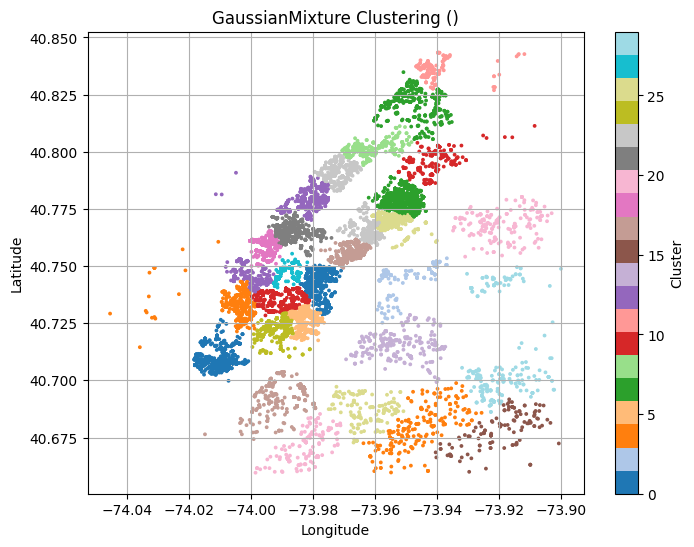

In [ ]:
gmm = GaussianMixture(n_components=30)
labels_gmm = gmm.fit_predict(X_train)

print(f"Silhouette Score: {silhouette_score(X_train, labels_gmm):.4f}")
print(f"Distortion: {distortion(X_train, labels_gmm):.2f}")

plt.figure(figsize=(8, 6))
plot(X_sub, labels_agg, 'GaussianMixture')
plt.show()

In [ ]:
lasso_coef(X_train, y_train, labels_gmm)

Top Feature Importances (Lasso Coefficients):
longitude           : -3896.15917
latitude            : 1126.80834
cluster             : -217.74945


### Different sets of features

In [ ]:
feature_sets = {
    "base": ['longitude', 'latitude', 'bedrooms', 'bathrooms', 'interest_level'],
    "geo": ['longitude', 'latitude', 'price'],
    "init": ['longitude', 'latitude',]}

In [ ]:
def remove_outliers_iqr(df, features):
  df_clean = df.copy()
  for feature in features:
    Q1 = df_clean[feature].quantile(0.25)
    Q3 = df_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]
  return df_clean

def plot_clusters(X, labels, title, ax=None):
  if ax is None:
      ax = plt.gca()
  scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20', s=10)
  ax.set_title(title)

def print_metrics(X1, X2, X3, L1, L2, L3):
  print(f"Silhouette Score Base: {silhouette_score(X1, L1):.4f}")
  print(f"Distortion Base: {distortion(X1, L1):.2f}")
  print(f"Silhouette Score Geo: {silhouette_score(X2, L2):.4f}")
  print(f"Distortion Geo: {distortion(X2, L2):.2f}")
  print(f"Silhouette Score Init: {silhouette_score(X3, L3):.4f}")
  print(f"Distortion Init: {distortion(X3, L3):.2f}")

def visualize(model, X1, X2, X3, L1, L2, L3):
  fig = plt.figure(figsize=(16, 12))
  gs = GridSpec(2, 2, height_ratios=[1, 1])
  ax1 = fig.add_subplot(gs[0, 0])
  plot_clusters(X1, L1, f'{model} Base', ax=ax1)
  ax2 = fig.add_subplot(gs[0, 1])
  plot_clusters(X2, L2, f'{model} Geo', ax=ax2)
  ax3 = fig.add_subplot(gs[1, :])
  plot_clusters(X3, L3, f'{model} Init', ax=ax3)
  plt.tight_layout()
  plt.show()

In [ ]:
X_train_base = remove_outliers_iqr(train[feature_sets['base']], feature_sets['base'])
X_train_geo = remove_outliers_iqr(train[feature_sets['geo']], feature_sets['geo'])
X_train_init = remove_outliers_iqr(train[feature_sets['init']], feature_sets['init'])

X_scaled_base = StandardScaler().fit_transform(X_train_base)
X_scaled_geo = StandardScaler().fit_transform(X_train_geo)
X_scaled_init = StandardScaler().fit_transform(X_train_init)

Time: 1.303565502166748


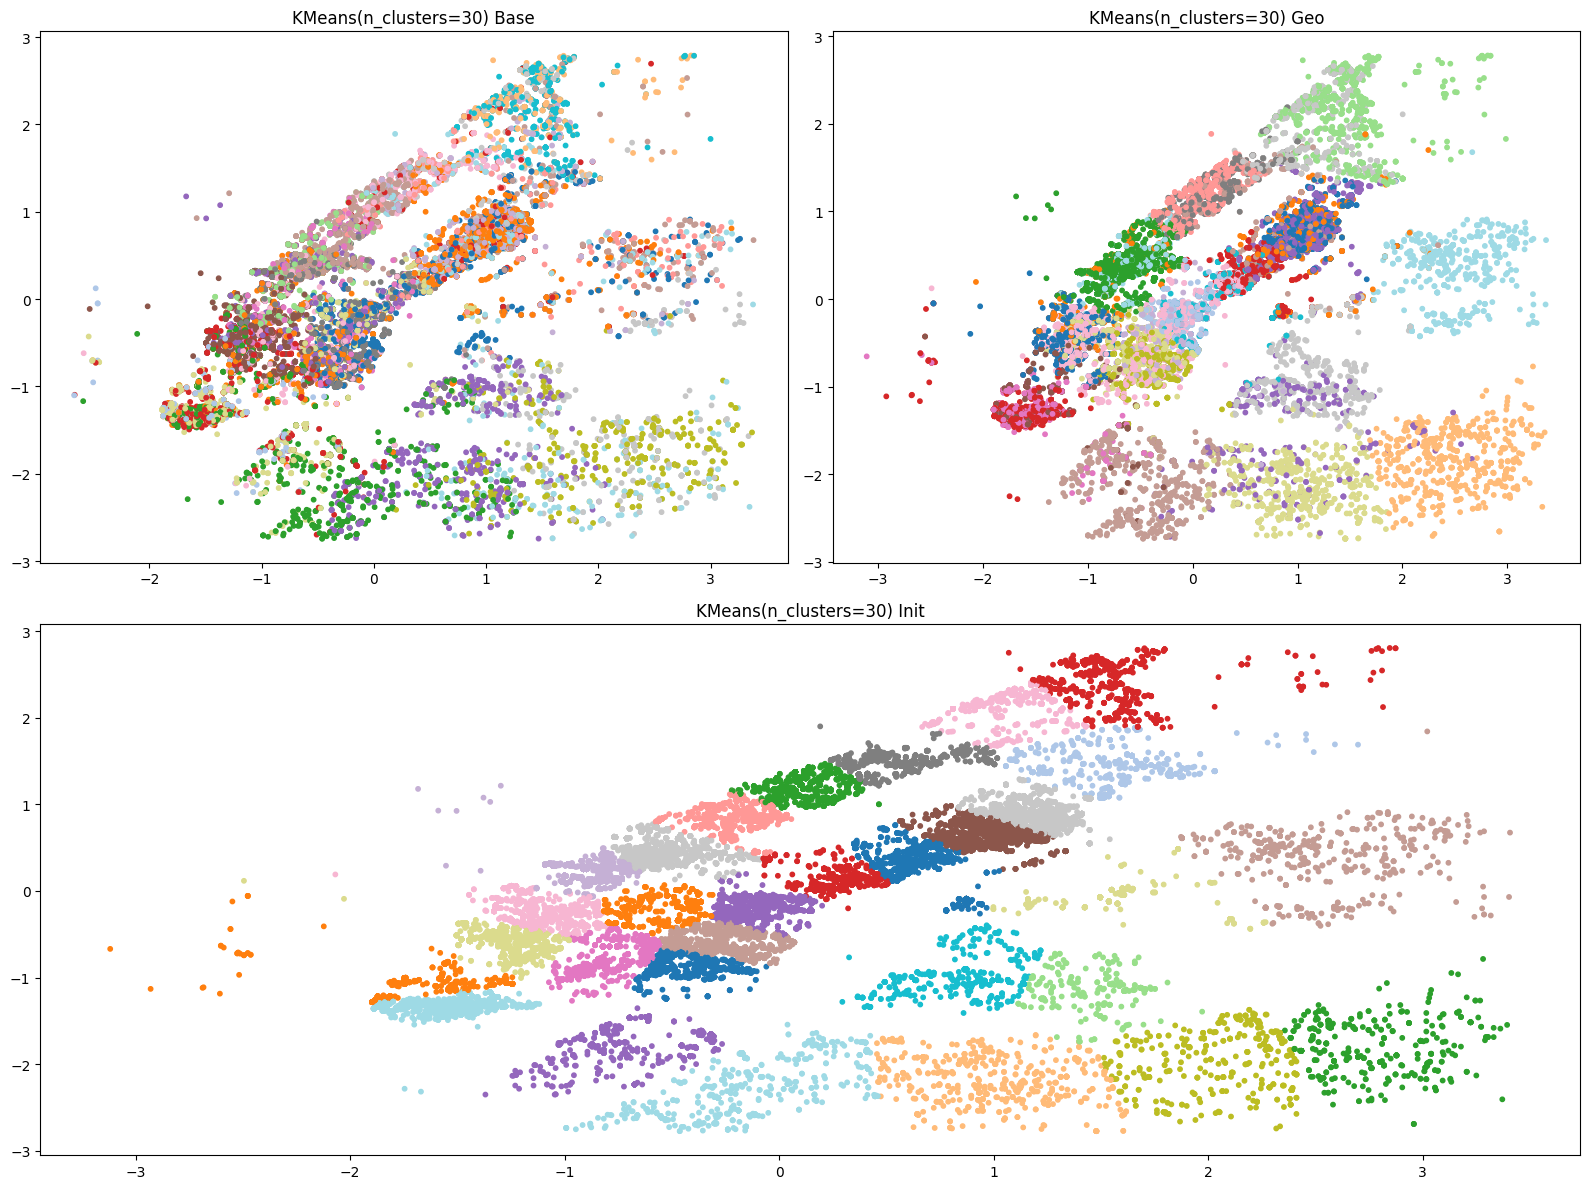

In [ ]:
start = time.time()

model = KMeans(n_clusters=30)
labels_base = model.fit_predict(X_scaled_base)
labels_geo = model.fit_predict(X_scaled_geo)
labels_init = model.fit_predict(X_scaled_init)

print(f"Time: {time.time() - start}")

visualize(model, X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

In [ ]:
print_metrics(X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

Silhouette Score Base: 0.3453
Distortion Base: 20145.47
Silhouette Score Geo: 0.3102
Distortion Geo: 10835.99
Silhouette Score Init: 0.3978
Distortion Init: 2302.86


Time: 3.5708770751953125


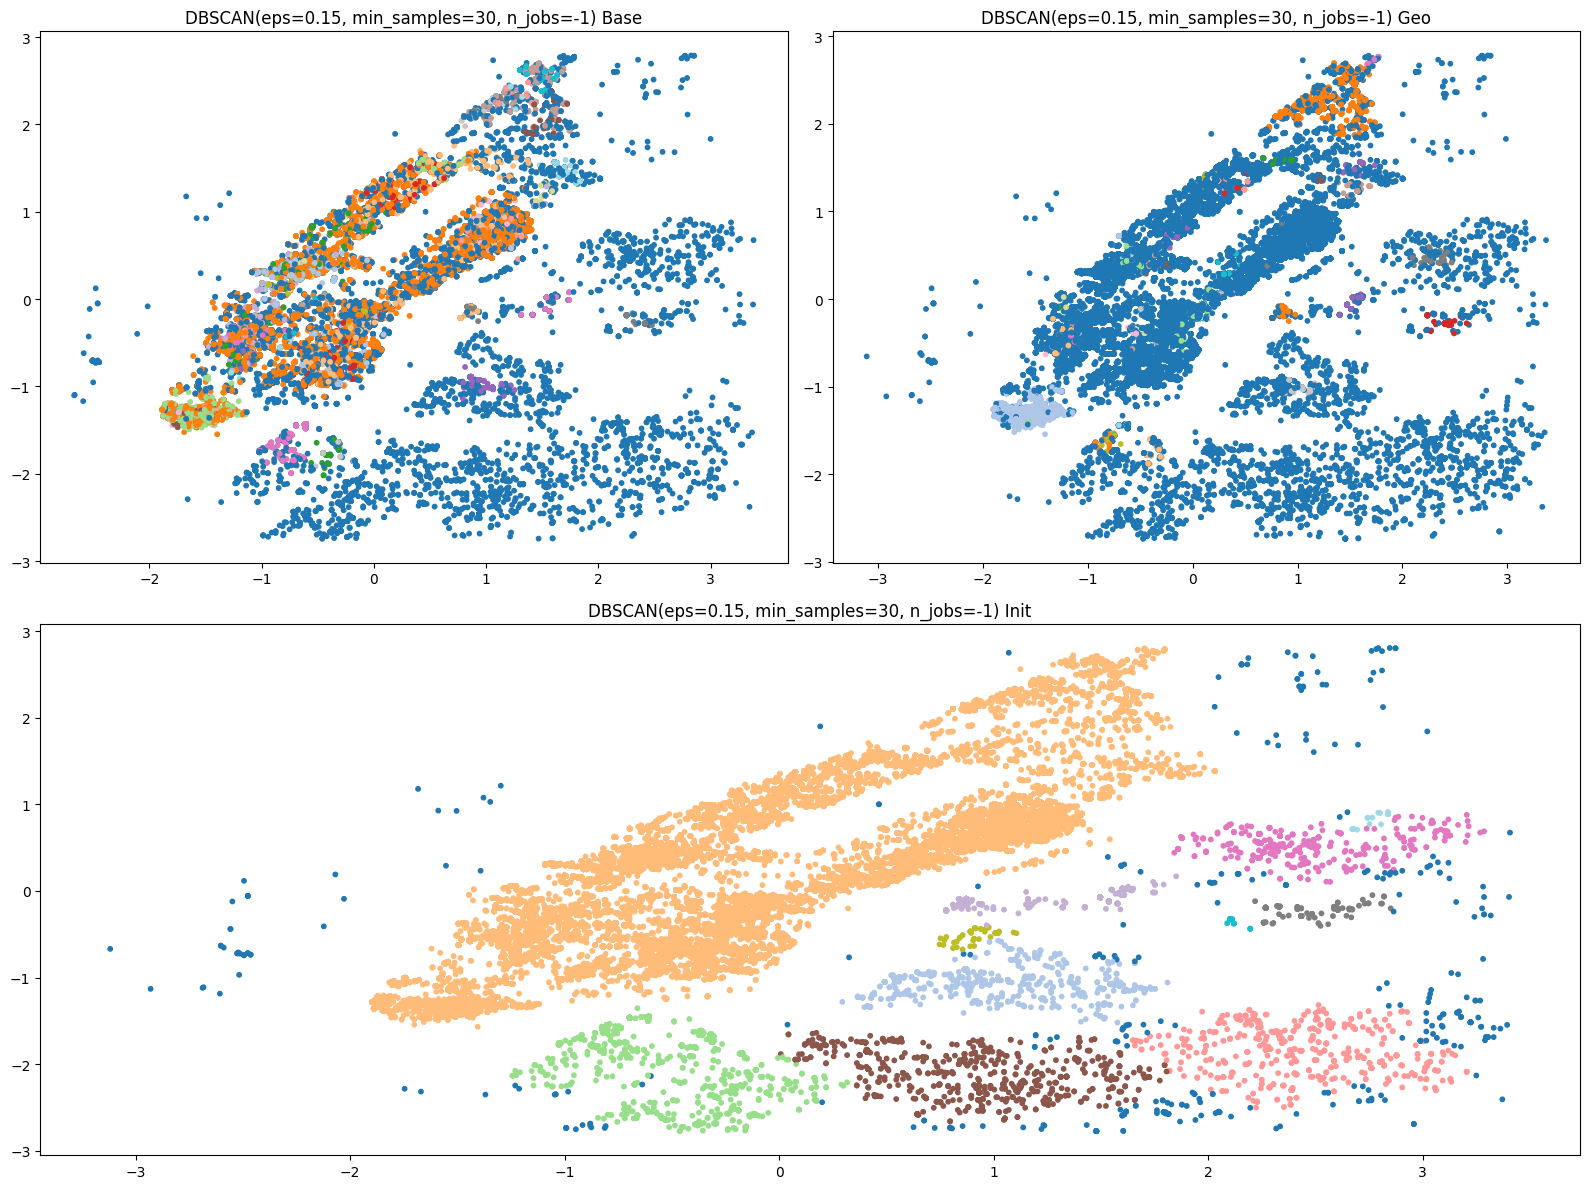

In [ ]:
start = time.time()

model = DBSCAN(eps=0.15, min_samples=30, n_jobs=-1)
labels_base = model.fit_predict(X_scaled_base)
labels_geo = model.fit_predict(X_scaled_geo)
labels_init = model.fit_predict(X_scaled_init)

print(f"Time: {time.time() - start}")

visualize(model, X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

In [ ]:
print_metrics(X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

Silhouette Score Base: -0.0701
Distortion Base: 65807.47
Silhouette Score Geo: -0.4538
Distortion Geo: 93034.99
Silhouette Score Init: -0.0530
Distortion Init: 68733.72


Time: 80.55445551872253


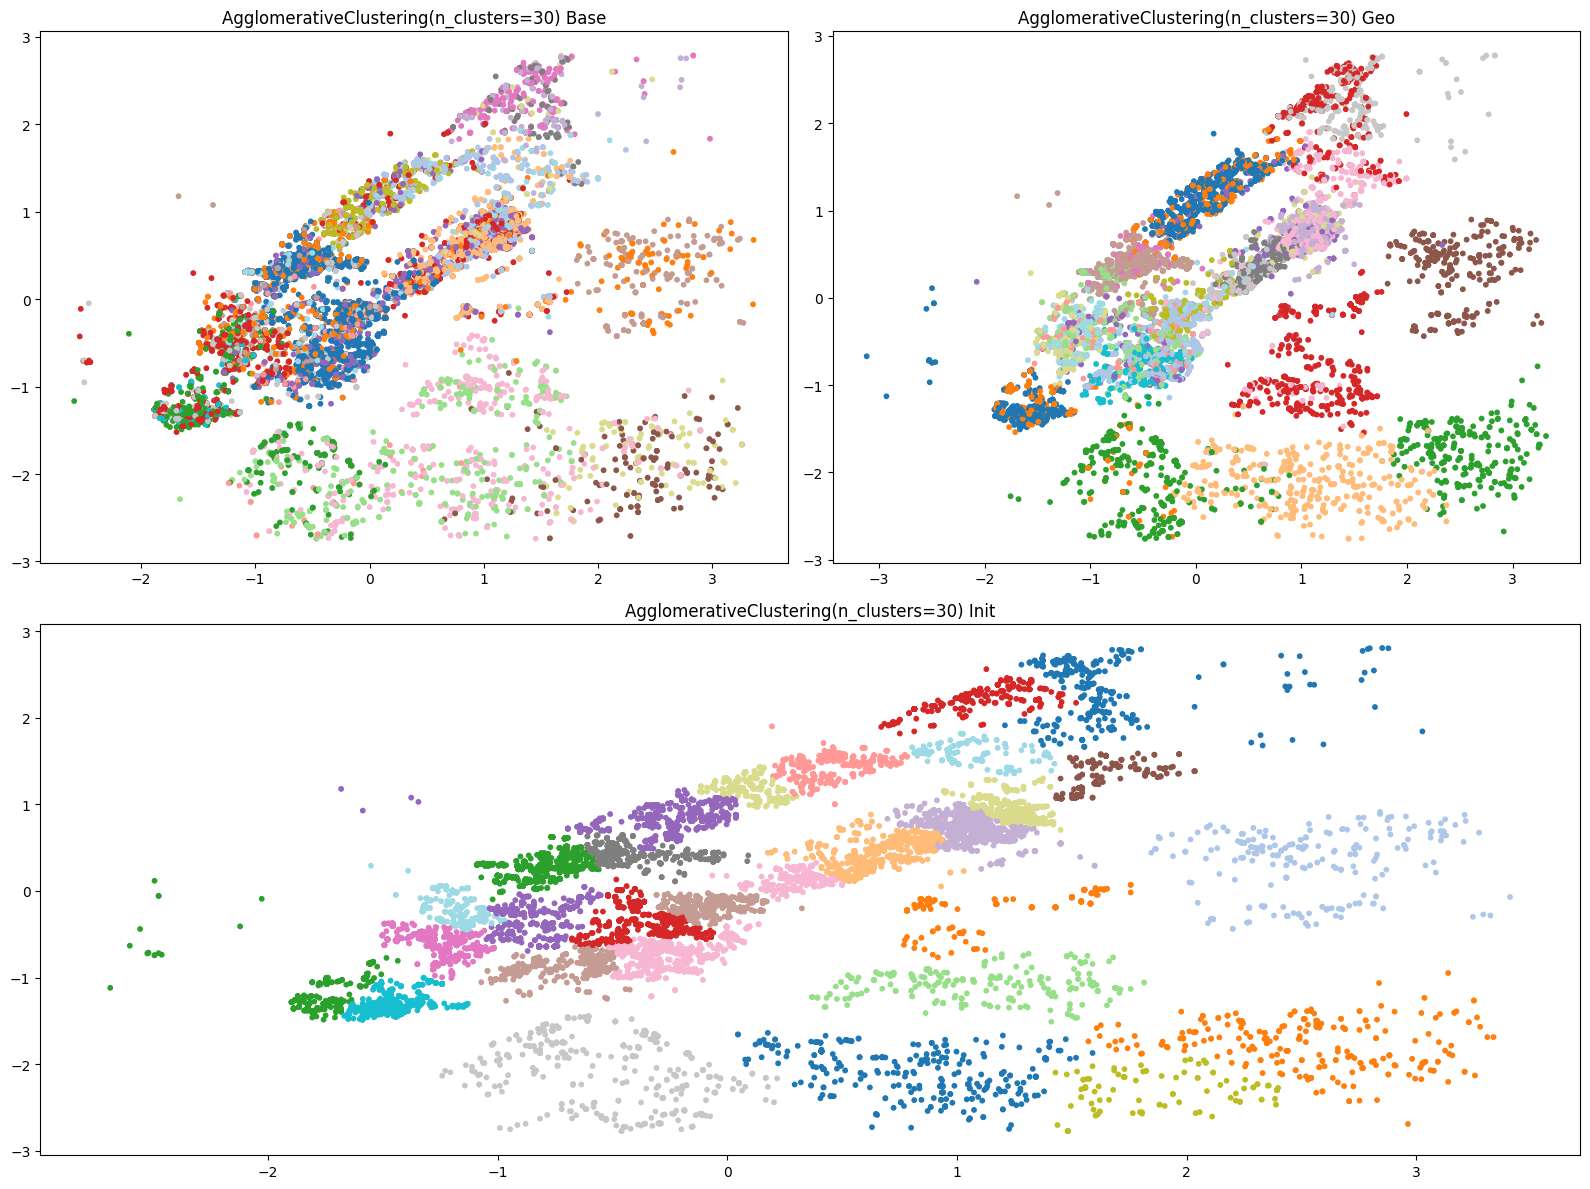

In [ ]:
start = time.time()

X_sub_base = X_train_base.sample(20000)
X_sub_geo = X_train_geo .sample(20000)
X_sub_init = X_train_init.sample(20000)
X_scaled_base = StandardScaler().fit_transform(X_sub_base)
X_scaled_geo = StandardScaler().fit_transform(X_sub_geo)
X_scaled_init = StandardScaler().fit_transform(X_sub_init)

model = AgglomerativeClustering(n_clusters=30)
labels_base = model.fit_predict(X_scaled_base)
labels_geo = model.fit_predict(X_scaled_geo)
labels_init = model.fit_predict(X_scaled_init)

print(f"Time: {time.time() - start}")

visualize(model, X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

In [ ]:
print_metrics(X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

Silhouette Score Base: 0.3370
Distortion Base: 11164.24
Silhouette Score Geo: 0.2528
Distortion Geo: 5747.64
Silhouette Score Init: 0.3843
Distortion Init: 1054.95


Time: 17.21848726272583


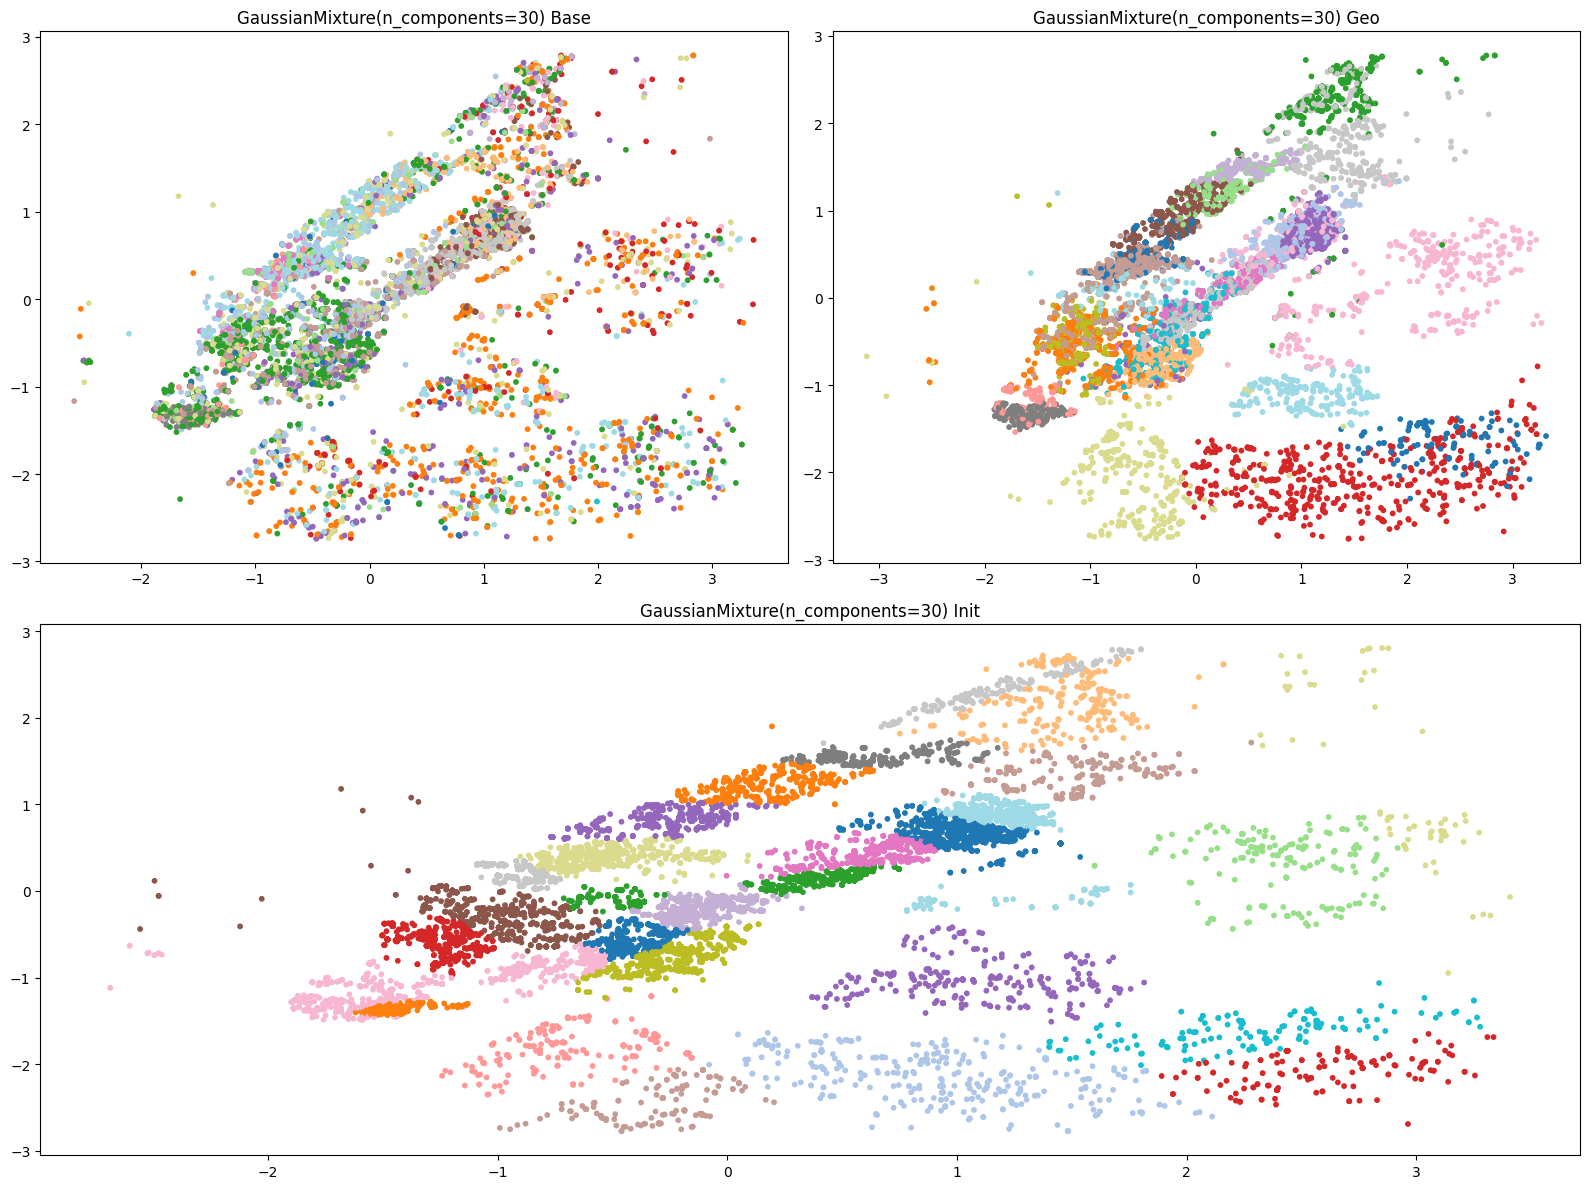

In [ ]:
start = time.time()

model = GaussianMixture(n_components=30)
labels_base = model.fit_predict(X_scaled_base)
labels_geo = model.fit_predict(X_scaled_geo)
labels_init = model.fit_predict(X_scaled_init)

print(f"Time: {time.time() - start}")

visualize(model, X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

In [ ]:
print_metrics(X_scaled_base, X_scaled_geo, X_scaled_init, labels_base, labels_geo, labels_init)

Silhouette Score Base: 0.1792
Distortion Base: 21926.59
Silhouette Score Geo: 0.2060
Distortion Geo: 7309.96
Silhouette Score Init: 0.3460
Distortion Init: 1222.52


### Bonus

In [216]:
train_df = pd.merge(X_train, y_train, how='outer', left_index=True, right_index=True)
test_df = pd.merge(X_test, y_test, how='outer', left_index=True, right_index=True)

train_df_clean = remove_outliers_iqr(train_df, train_df.columns)
test_df_clean = remove_outliers_iqr(test_df, test_df.columns)

X_train_b, y_train_b = train_df_clean.iloc[:, :-1], train_df_clean.iloc[:, -1]
X_test_b, y_test_b = test_df_clean.iloc[:, :-1], test_df_clean.iloc[:, -1]

In [245]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_b, y_train_b)
y_pred = model.predict(X_test_b)

print('R2:', r2_score(y_test_b, y_pred))
print('MAE:', mean_absolute_error(y_test_b, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test_b, y_pred)))

for name, feature in zip(X_train.columns, model.feature_importances_):
  print(f'{name}: {feature:.4f}')

R2: 0.5162625620274308
MAE: 504.61591817643165
RMSE: 714.7507372624735
longitude: 0.5604
latitude: 0.4396


In [275]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.75)
model.fit(X_train_b, y_train_b)
y_pred = model.predict(X_test_b)

print('R2:', r2_score(y_test_b, y_pred))
print('MAE:', mean_absolute_error(y_test_b, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test_b, y_pred)))

for name, feature in zip(X_train.columns, model.feature_importances_):
  print(f'{name}: {feature:.4f}')

R2: 0.4538520574569702
MAE: 562.4354858398438
RMSE: 759.4600466779012
longitude: 0.5436
latitude: 0.4564


In [276]:
X_scaled = StandardScaler().fit_transform(X_train_b)

best_score = -1
best_k = 0
for k in range(20, 41, 5):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k
print(f"Best k: {best_k} with silhouette score: {best_score:.4f}")

Best k: 20 with silhouette score: 0.4477


In [281]:
X_combined = X_train.copy()
X_scaled = StandardScaler().fit_transform(X_combined)
X_combined['kmeans_cluster'] = KMeans(n_clusters=20).fit_predict(X_scaled)
X_combined['gmm_cluster'] = GaussianMixture(n_components=20).fit_predict(X_scaled)

In [287]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_combined, y_train)

for name, feature in zip(X_combined.columns, model.feature_importances_):
  print(f'{name}: {feature:.4f}')

longitude: 0.3970
latitude: 0.3622
kmeans_cluster: 0.0993
gmm_cluster: 0.1414


In [289]:
model = XGBRegressor(n_estimators=100, learning_rate=0.75)
model.fit(X_combined, y_train)

for name, feature in zip(X_combined.columns, model.feature_importances_):
  print(f'{name}: {feature:.4f}')

longitude: 0.1501
latitude: 0.8151
kmeans_cluster: 0.0088
gmm_cluster: 0.0260
